In [98]:
import numpy as np
import sympy as sp
from scipy import optimize
import matplotlib.pyplot as plt

Suppose very accurate values of some function $f (x)$ are given at the points $0 = x_0, x_1, \cdots , x_{100} = 1$, with the ${x_i}$ uniformly distributed over the interval [0, 1].

(So $x_i = \frac{i}{100}, i = 0, \cdots , 100$.)

The values $\{f (x_i)\}$ are given in the file 'problem2.txt' in sequential order

(so, for example, $f (0.27) = f (x_{27}) = -0.964603914513021$).

Use the method of normal equations discussed in class, to find a description of $f (x)$ as the sum of a very few polynomials and cosines and sines.
(You may be able to guess the answer since the function is fairly simple, but please also use the method of normal equations.)

For code, submit any code you used.
In your pdf, replicate any code you would like the TAs to see, show your results and explain how you obtained them.
If your search for a solution first considered some incorrect solutions, mention those and say how they informed your search for the correct solution.

In [99]:
xi = np.arange(0, 100 + 1) / 100
yi = np.loadtxt("../data/problem2.txt")

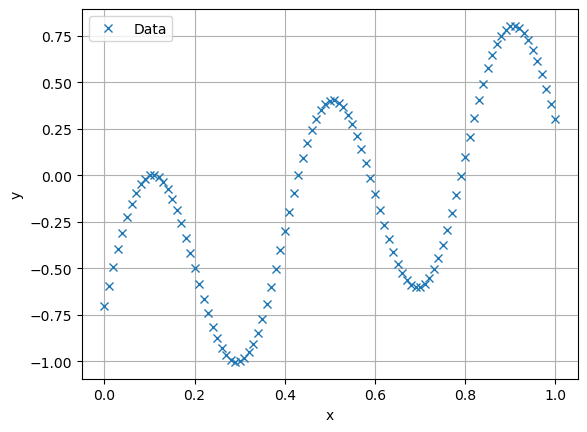

In [100]:
# Plot the data
plt.plot(xi, yi, "x", label="Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

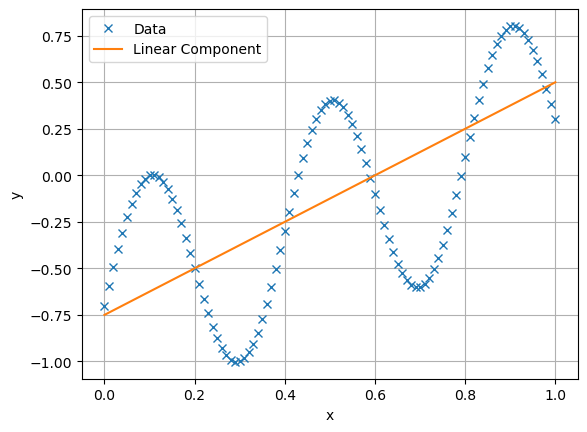

In [101]:
# It looks like there's linear function that passes through (0, -0.75) and (0.2, -0.5)
# Let's plot it along with the data
x = sp.symbols("x", real=True)
f = 1.25 * x - 0.75
f_numerical = sp.lambdify(x, f)

plt.plot(xi, yi, "x", label="Data")
plt.plot(xi, f_numerical(xi), label="Linear Component")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

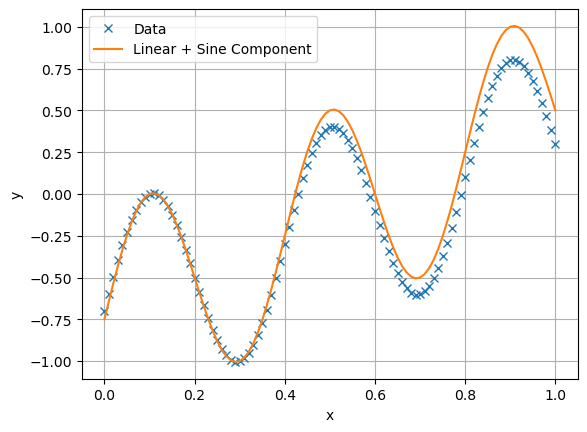

In [102]:
# The other component is a sine function, let's put them together
x = sp.symbols("x", real=True)
f = 1.25 * x - 0.75 + 0.625 * sp.sin(5 * sp.pi * x)
f_numerical = sp.lambdify(x, f)

plt.plot(xi, yi, "x", label="Data")
plt.plot(xi, f_numerical(xi), label="Linear + Sine Component")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.savefig("../figs/Q2_guess.png")
plt.show()


[Hint: Try to express $f (x)$ as a linear combination of the functions, $1, x, x^2, \cdots , cos(\pi x), sin(\pi x), cos(2\pi x), sin(2\pi x), \cdots$.
Use the method of normal equations.
That method will not be enough by itself, since the underlying functions are redundant (more than a basis).
However, that method is useful as a subroutine in a search.
Try to find a very simple description of the function $f (x)$ by determining which coefficients in your sum may be
set to zero.
There may be multiple candidate answers; find one with the fewest nonzero coefficients.
Graphing the function may be helpful in your search.
You should need at most 3 nonzero coefficients when writing f (x) as a sum of the functions $1, x, x^2, \cdots , cos(\pi x), sin(\pi x), cos(2\pi x), sin(2\pi x), \cdots$.]

In [103]:
def normal_equation_method(
    xi: np.array, yi: np.array, n_poly: int, n_trig: int, tol: float = 1e-5
):
    """Use the method of normal equations to fit a polynomial and trigonometric function to the data.

    Args:
        xi (np.array): xi data points
        yi (np.array): fi data points
        n_poly (int): number of polynomial terms
        n_trig (int): number of trigonometric terms
        tol (float, optional): tolerance for filtering out small coefficients. Defaults to 1e-5.
    """

    xi = xi.reshape(-1, 1).copy()
    yi = yi.reshape(-1, 1).copy()

    assert xi.shape == yi.shape, "xi and yi must have the same shape"

    # Construct the design matrix
    A = np.zeros((len(xi), n_poly + 2 * n_trig))
    for i in range(n_poly):
        A[:, i] = (xi**i)[:, 0]
    for i in range(n_trig):
        A[:, n_poly + i] = np.sin((i + 1) * np.pi * xi)[:, 0]
        A[:, n_poly + n_trig + i] = np.cos((i + 1) * np.pi * xi)[:, 0]

    # Use least squares to solve for the coefficients
    coeff, _, _, _ = np.linalg.lstsq(A, yi, rcond=None)

    # Filter out coefficients that are close to zero
    coeff[np.abs(coeff) < tol] = 0

    x = sp.symbols("x", real=True)

    p = 0
    for i in range(n_poly):
        p += coeff[i] * x**i
    for i in range(n_trig):
        p += coeff[n_poly + i] * sp.sin((i + 1) * sp.pi * x)
        p += coeff[n_poly + n_trig + i] * sp.cos((i + 1) * sp.pi * x)

    return sp.simplify(p), coeff

In [104]:
n_poly = 5
n_trig = 5

p, coeff = normal_equation_method(xi, yi, n_poly, n_trig)

print(
    f"Approximate data points with degree {n_poly} polynomial and {n_trig} trigonometric terms:"
)
sp.pprint(p)

Approximate data points with degree 5 polynomial and 5 trigonometric terms:
[0.999999980668295⋅x + 0.600000000000149⋅sin(5⋅π⋅x) - 0.699999999335618]


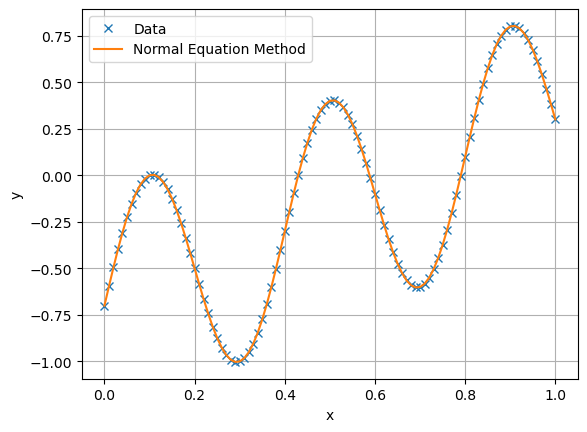

In [105]:
# Plot p along with the data
x = sp.symbols("x", real=True)
p_numerical = sp.lambdify(x, p)

plt.plot(xi, yi, "x", label="Data")
plt.plot(xi, p_numerical(xi).squeeze(), label="Normal Equation Method")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.savefig("../figs/Q2_fit.png")
plt.show()